In [43]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
from itertools import islice, cycle

from graspy.embed import JointRDPG
from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize
from graspy.cluster import GaussianCluster, KMeansCluster

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import rho_sbm_marg, rho_ER_marg, sbm_marg_corr_diff
from utils import sbm_params, permute_matrix, triu_no_diag, to_distance_mtx, identity, power

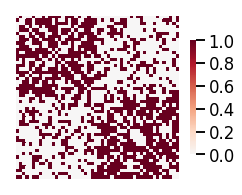

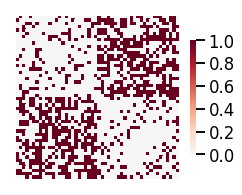

In [18]:
n = 50
k = 2
A, B = rho_sbm_marg(rho=0.3, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.2, b=0.5), n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [3]:
true_assignments = np.repeat(np.arange(0, k), repeats=n//k)
colors = np.array(['#377eb8', '#ff7f00', '#4daf4a',
                    '#f781bf', '#a65628', '#984ea3',])

In [4]:
jrdpg = JointRDPG()
jrdpg.fit([A, B])
Vhat = jrdpg.latent_left_

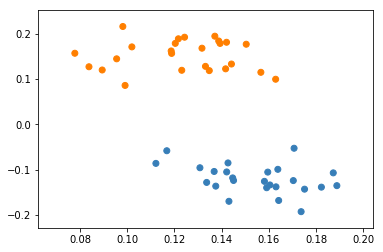

In [5]:
plt.scatter(x=Vhat[:,0], y=Vhat[:, 1], color=colors[true_assignments])

In [6]:
gmm = GaussianCluster(max_components=2)
est_assignment = gmm.fit_predict(Vhat)

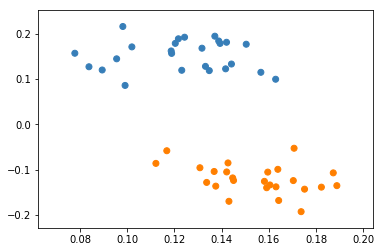

In [7]:
plt.scatter(x=Vhat[:,0], y=Vhat[:, 1], color=colors[est_assignment])

In [8]:
def estimate_block_assignment(A, B):
    jrdpg = JointRDPG()
    jrdpg.fit([A, B])
    Vhat = jrdpg.latent_left_
    gmm = GaussianCluster(max_components=2)
    est_assignment = gmm.fit_predict(Vhat)
    return est_assignment

In [12]:
def permute_edges(A):
    return np.random.permutation(A)

In [34]:
def block_permute(A, block_assignment):
    permuted_A = np.zeros_like(A)
    unique_blocks = np.unique(block_assignment)
    for i in unique_blocks:
        block_i_idx = np.where(block_assignment == i)[0]
        for j in unique_blocks:
            block_j_idx = np.where(block_assignment == j)[0]
            block = A[np.ix_(block_i_idx, block_j_idx)]
            if i == j:
                permuted_block = permute_matrix(block)
            else:
                permuted_block = permute_edges(block)
            permuted_A[np.ix_(block_i_idx, block_j_idx)] = permuted_block
    permuted_A = symmetrize(permuted_A)
    return permuted_A

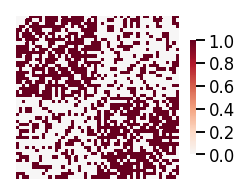

In [35]:
heatmap(A, figsize=(4, 3))

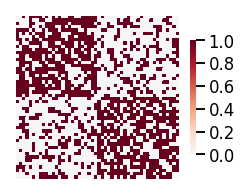

In [36]:
heatmap(block_permute(A, est_assignment), figsize=(4, 3))

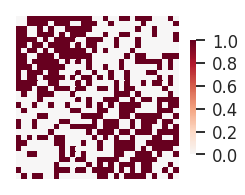

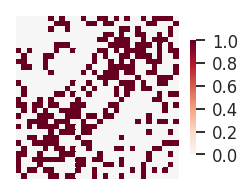

In [76]:
A, B = rho_sbm_marg(rho=0.1, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.2, b=0.5), n=30)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [77]:
estimate_block_assignment(A, B)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
def rho_sbm_power(indept_test, transform_func, rho, P1, P2, k=2, n=50, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_sbm_marg(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B)
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [40]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=2, n=n)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=2, n=n)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=2, n=n)
            power_sbm[name][i, j] = test_power

finish pearson rho=0.0, n=10
finish pearson rho=0.0, n=20
finish pearson rho=0.0, n=30
finish pearson rho=0.0, n=40
finish pearson rho=0.0, n=50
finish pearson rho=0.0, n=60
finish pearson rho=0.0, n=70
finish pearson rho=0.0, n=80
finish pearson rho=0.0, n=90
finish pearson rho=0.0, n=100
finish pearson rho=0.1, n=10
finish pearson rho=0.1, n=20
finish pearson rho=0.1, n=30
finish pearson rho=0.1, n=40
finish pearson rho=0.1, n=50
finish pearson rho=0.1, n=60
finish pearson rho=0.1, n=70
finish pearson rho=0.1, n=80
finish pearson rho=0.1, n=90
finish pearson rho=0.1, n=100
finish dcorr rho=0.0, n=10
finish dcorr rho=0.0, n=20
finish dcorr rho=0.0, n=30
finish dcorr rho=0.0, n=40
finish dcorr rho=0.0, n=50
finish dcorr rho=0.0, n=60
finish dcorr rho=0.0, n=70
finish dcorr rho=0.0, n=80
finish dcorr rho=0.0, n=90
finish dcorr rho=0.0, n=100
finish dcorr rho=0.1, n=10
finish dcorr rho=0.1, n=20
finish dcorr rho=0.1, n=30
finish dcorr rho=0.1, n=40
finish dcorr rho=0.1, n=50
finish dcorr

/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/Ne

finish mgc rho=0.0, n=10
finish mgc rho=0.0, n=20
finish mgc rho=0.0, n=30
finish mgc rho=0.0, n=40
finish mgc rho=0.0, n=50
finish mgc rho=0.0, n=60
finish mgc rho=0.0, n=70
finish mgc rho=0.0, n=80
finish mgc rho=0.0, n=90
finish mgc rho=0.0, n=100


/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/NeuroData/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/Ne

finish mgc rho=0.1, n=10
finish mgc rho=0.1, n=20
finish mgc rho=0.1, n=30
finish mgc rho=0.1, n=40
finish mgc rho=0.1, n=50
finish mgc rho=0.1, n=60
finish mgc rho=0.1, n=70
finish mgc rho=0.1, n=80
finish mgc rho=0.1, n=90
finish mgc rho=0.1, n=100


In [41]:
power_sbm

{'pearson': array([[0.094, 0.084, 0.058, 0.054, 0.048, 0.054, 0.058, 0.07 , 0.044,
         0.06 ],
        [0.024, 0.008, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   ]]),
 'dcorr': array([[0.004, 0.002, 0.   , 0.054, 0.048, 0.05 , 0.036, 0.046, 0.04 ,
         0.068],
        [0.014, 0.014, 0.084, 0.78 , 0.872, 0.972, 1.   , 0.998, 1.   ,
         1.   ]]),
 'mgc': array([[0.01 , 0.   , 0.002, 0.032, 0.05 , 0.072, 0.044, 0.062, 0.034,
         0.048],
        [0.028, 0.03 , 0.082, 0.772, 0.874, 0.968, 0.99 , 1.   , 1.   ,
         1.   ]])}

In [44]:
n_arr = np.linspace(10, 100, 10, dtype=int)
mpl.style.use('seaborn')

plt.figure(figsize=(8, 6))
colors = {
    'mgc': 'red',
    'dcorr': 'blue', 
    'pearson': 'orange'
}

<Figure size 576x432 with 0 Axes>

In [47]:
with open('../data/rho_sbm_marg_est_block_power.pkl', 'rb') as f:
    power_results = pickle.load(f)

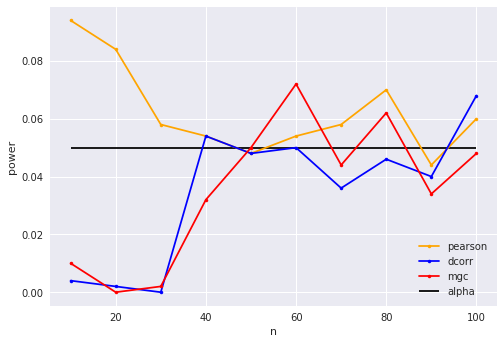

In [49]:
rho = 0
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[0, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=0.05, xmin=np.amin(n_arr), xmax=np.amax(n_arr), label='alpha')
plt.legend(loc=4)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_marg_est_block_power_null.png', bbox_inches='tight')

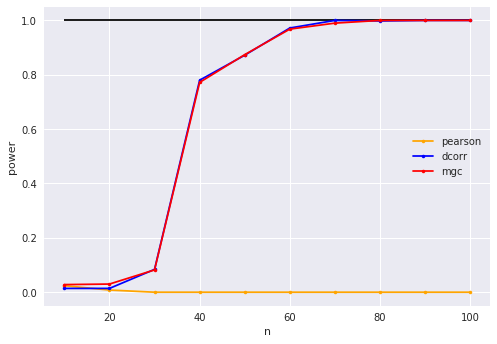

In [50]:
rho = 0.1
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[1, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=1, xmin=np.amin(n_arr), xmax=np.amax(n_arr))
plt.legend(loc=7)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_marg_est_block_power_alt.png'.format(rho), bbox_inches='tight')